In [83]:
import os
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import time
pd.options.mode.chained_assignment = None  # default='warn'

In [84]:
csvfile = 'oracle-ETE-XTimeData_PA_NO_TRACES.csv'
csvdf = pd.read_csv(csvfile, sep=',')

In [85]:
print(csvdf.head())

  progname probSize   papiCounter  cntrMode  trialnum  eteXtime
0   nas_ft  medprob  PAPI_TOT_INS  alwaysOn         3     10.99
1   nas_ft  medprob  PAPI_TOT_INS  alwaysOn         0     10.92
2   nas_ft  medprob  PAPI_TOT_INS  alwaysOn         6     11.07
3   nas_ft  medprob  PAPI_TOT_INS  alwaysOn         2     11.00
4   nas_ft  medprob  PAPI_TOT_INS  alwaysOn         5     11.12


In [86]:
print(csvdf['cntrMode'].unique())

['alwaysOn' 'uniqueFeat']


In [87]:
# let's get the static xtime data for each of these programs
# we'll use this xtime as a reference
prognames = list(csvdf['progname'].unique())

In [88]:
# let's load up the static data csv
staticDF = pd.read_csv('cntrVariab-ETE-XTimeData_PA.csv', sep=',')
print(staticDF.head())

  progname probSize           policy   papiCounter    cntrMode  trialnum  \
0   nas_ft  medprob  Static,policy=0  PAPI_TOT_INS    alwaysOn         2   
1   nas_ft  medprob  Static,policy=0  PAPI_TOT_INS    alwaysOn         0   
2   nas_ft  medprob  Static,policy=0  PAPI_TOT_INS  uniqueFeat         0   
3   nas_ft  medprob  Static,policy=0  PAPI_TOT_INS    alwaysOn         1   
4   nas_ft  medprob  Static,policy=0  PAPI_TOT_INS  uniqueFeat         1   

   eteXtime  
0     10.91  
1     11.01  
2     11.02  
3     11.07  
4     10.64  


In [99]:
# average out the xtimes from the static data
#avrgOpt = staticDF.groupby(['papiCounter', 'cntrMode', 'policy', 'progname'])['eteXtime'].mean().reset_index()
avrgOpt = staticDF.groupby(['cntrMode', 'policy', 'progname'])['eteXtime'].mean().reset_index()

print(avrgOpt)

# let's pick the best static eteXtime for each program
beststatic = avrgOpt.groupby(['progname']).min().reset_index()
print(beststatic)

      cntrMode           policy     progname    eteXtime
0     alwaysOn  Static,policy=0       nas_ft   10.898667
1     alwaysOn  Static,policy=0       nas_sp   66.174333
2     alwaysOn  Static,policy=0  rodinia_cfd   11.333491
3     alwaysOn  Static,policy=1       nas_ft   17.541222
4     alwaysOn  Static,policy=1       nas_sp  113.491444
5     alwaysOn  Static,policy=1  rodinia_cfd   17.834650
6     alwaysOn  Static,policy=2       nas_ft  211.995444
7     alwaysOn  Static,policy=2       nas_sp  604.595333
8     alwaysOn  Static,policy=2  rodinia_cfd  234.488356
9   uniqueFeat  Static,policy=0       nas_ft   10.906667
10  uniqueFeat  Static,policy=0       nas_sp   66.043333
11  uniqueFeat  Static,policy=0  rodinia_cfd   11.189338
12  uniqueFeat  Static,policy=1       nas_ft   17.555778
13  uniqueFeat  Static,policy=1       nas_sp  113.554000
14  uniqueFeat  Static,policy=1  rodinia_cfd   17.737108
15  uniqueFeat  Static,policy=2       nas_ft  212.158444
16  uniqueFeat  Static,policy=2

In [124]:
def plotCntrTimingsForProg(progname, df):
    toplot = df[df['progname'] == progname].sort_values(by=['papiCounter'])
    
    # groupby counters and average trial times
    avrgd = toplot.groupby(['papiCounter', 'cntrMode'])['eteXtime'].mean().reset_index().sort_values(by=['papiCounter'])
    
    # get the data for two plot calls of the averages
    alwaysOnDF   = avrgd[avrgd['cntrMode'] == 'alwaysOn']
    uniqueFeatDF = avrgd[avrgd['cntrMode'] == 'uniqueFeat']
    
    # get the raw dots to show
    aoDF   = toplot[toplot['cntrMode'] == 'alwaysOn']
    ufDF = toplot[toplot['cntrMode'] == 'uniqueFeat']
    
    # convert the categorical papiCounter values to numerical
    papicntrs = list(avrgd['papiCounter'].unique())
    numcntrs = len(papicntrs)
    cntrmap = dict(zip(papicntrs, range(numcntrs)))
    
    alwaysOnDF['x'] = alwaysOnDF['papiCounter'].apply(lambda x: cntrmap[x])
    uniqueFeatDF['x'] = uniqueFeatDF['papiCounter'].apply(lambda x: cntrmap[x])
    aoDF['x'] = aoDF['papiCounter'].apply(lambda x: cntrmap[x])
    ufDF['x'] = ufDF['papiCounter'].apply(lambda x: cntrmap[x])
    
    #print(alwaysOnDF[alwaysOnDF['papiCounter'] == 'PAPI_BR_INS'])
    
    # setup our plot
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 10)
    fig.set_dpi(500)
    
    ax.scatter(x=aoDF['x']+0.1, y=aoDF['eteXtime'], label='alwaysOn', color='red')
    ax.scatter(x=ufDF['x']-0.1, y=ufDF['eteXtime'], label='uniqueFeat', color='pink')
    
    ax.scatter(x=alwaysOnDF['x']+0.1, y=alwaysOnDF['eteXtime'], label='alwaysOn-AVRG', marker='x', color='black')
    ax.scatter(x=uniqueFeatDF['x']-0.1, y=uniqueFeatDF['eteXtime'], label='uniqueFeat-AVRG', marker='x', color='black')
    
    bestxtime = beststatic.loc[beststatic['progname'] == progname]['eteXtime'].to_numpy()[0]
    print(bestxtime)
    ax.axhline(bestxtime, label='best static xtime')
    
    ax.set_xticks(list(cntrmap.values()))
    ax.set_xticklabels(list(cntrmap.keys()))
    ax.set_xlabel('Counter')
    ax.set_ylabel('End-To-End Execution Time (seconds)')
    ax.set_title(progname+' Counter as Feature Analysis')
    ax.set_yscale('log')
    plt.legend()

    plt.show()
    return

10.898666666666665


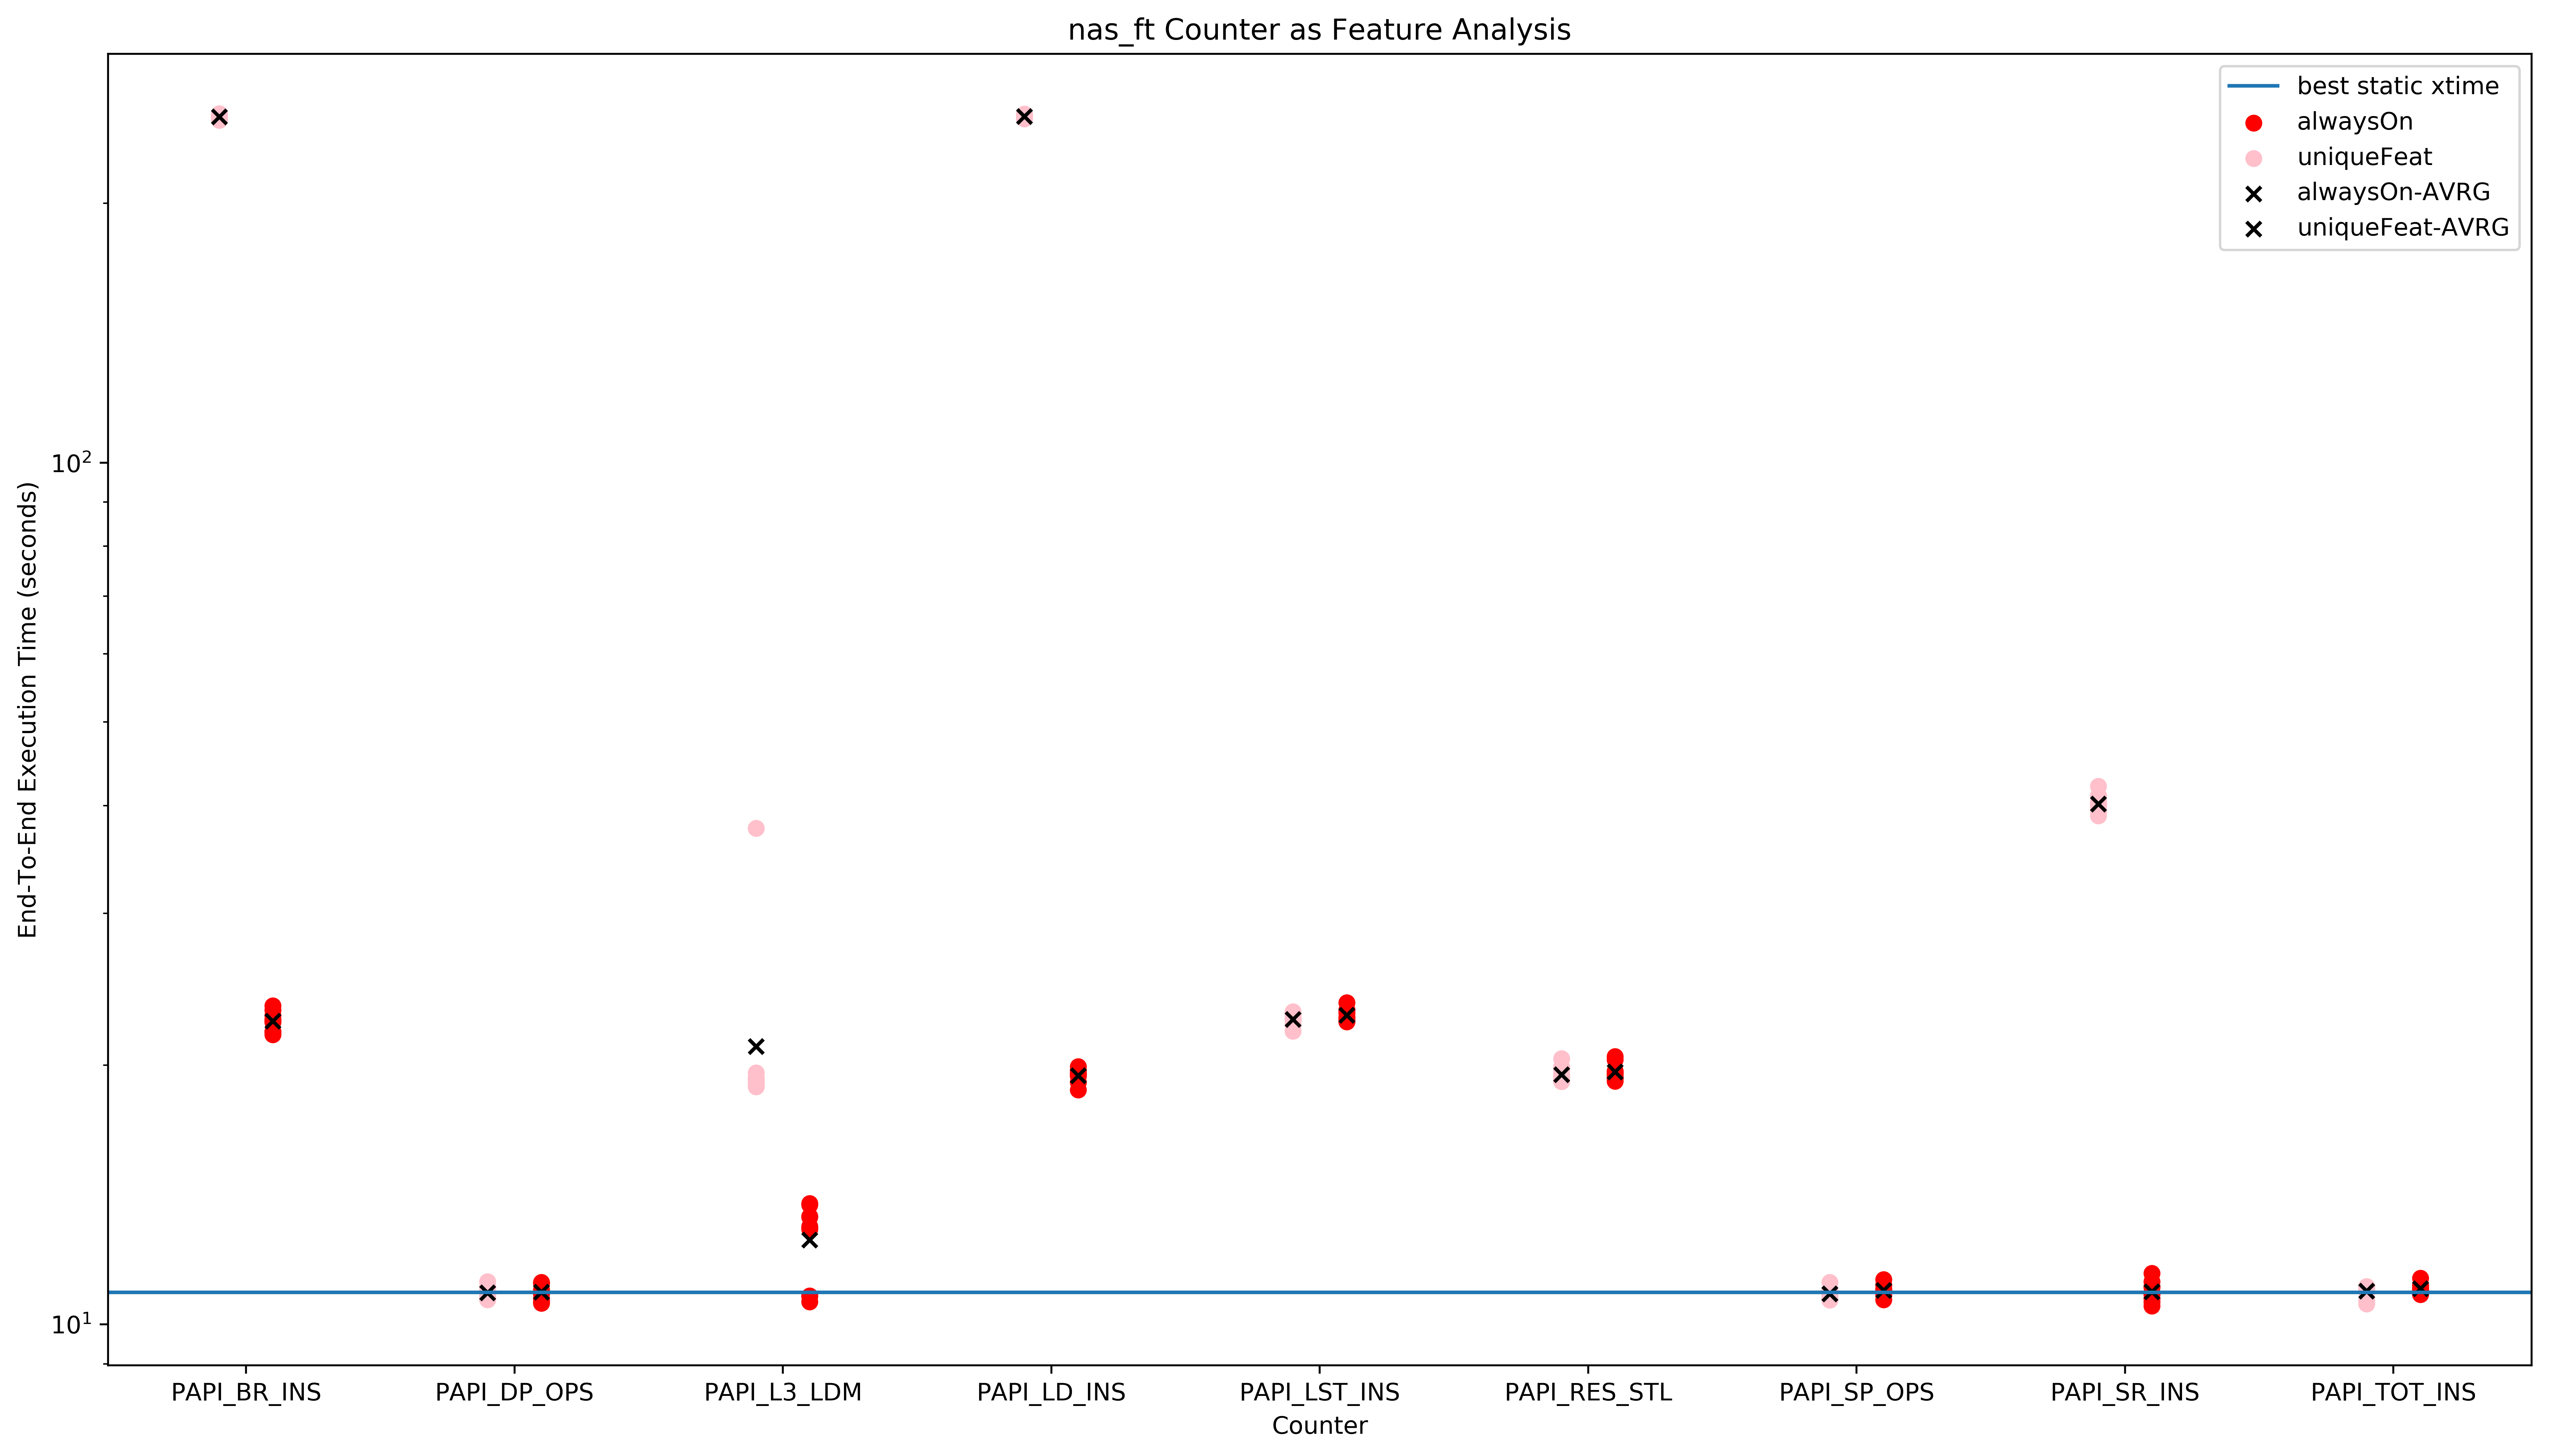

11.18933777777778


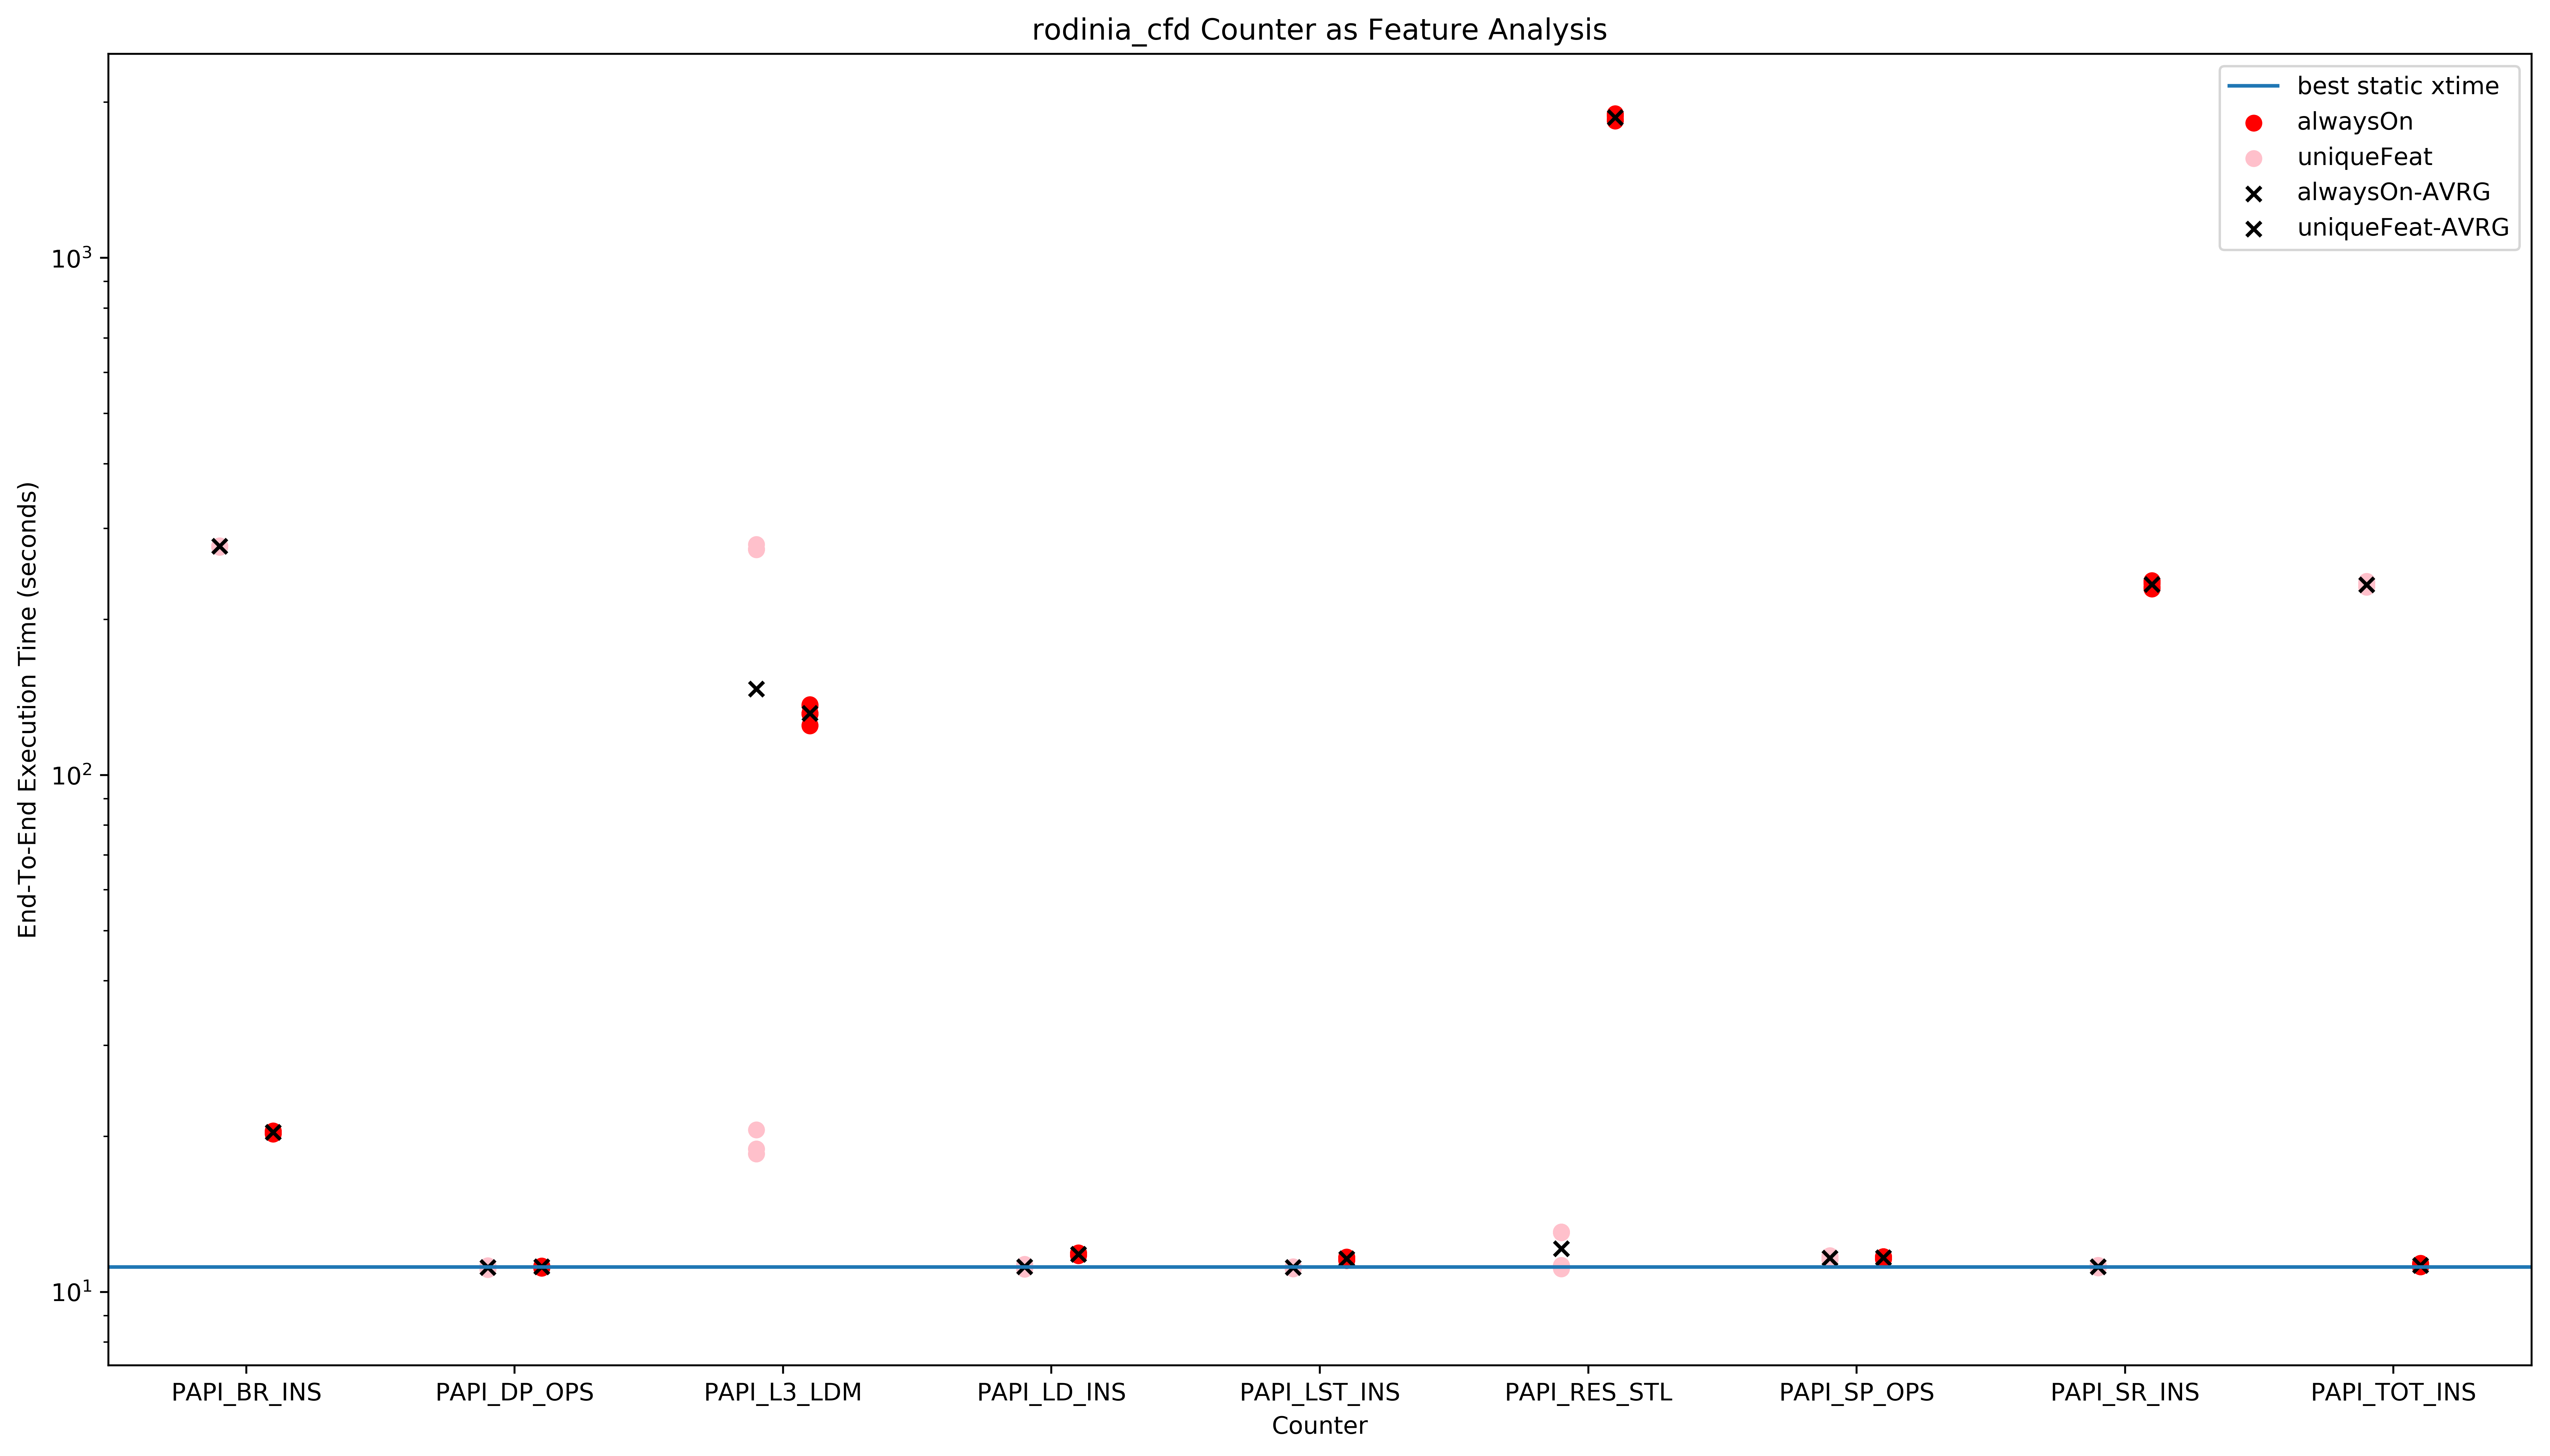

66.04333333333332


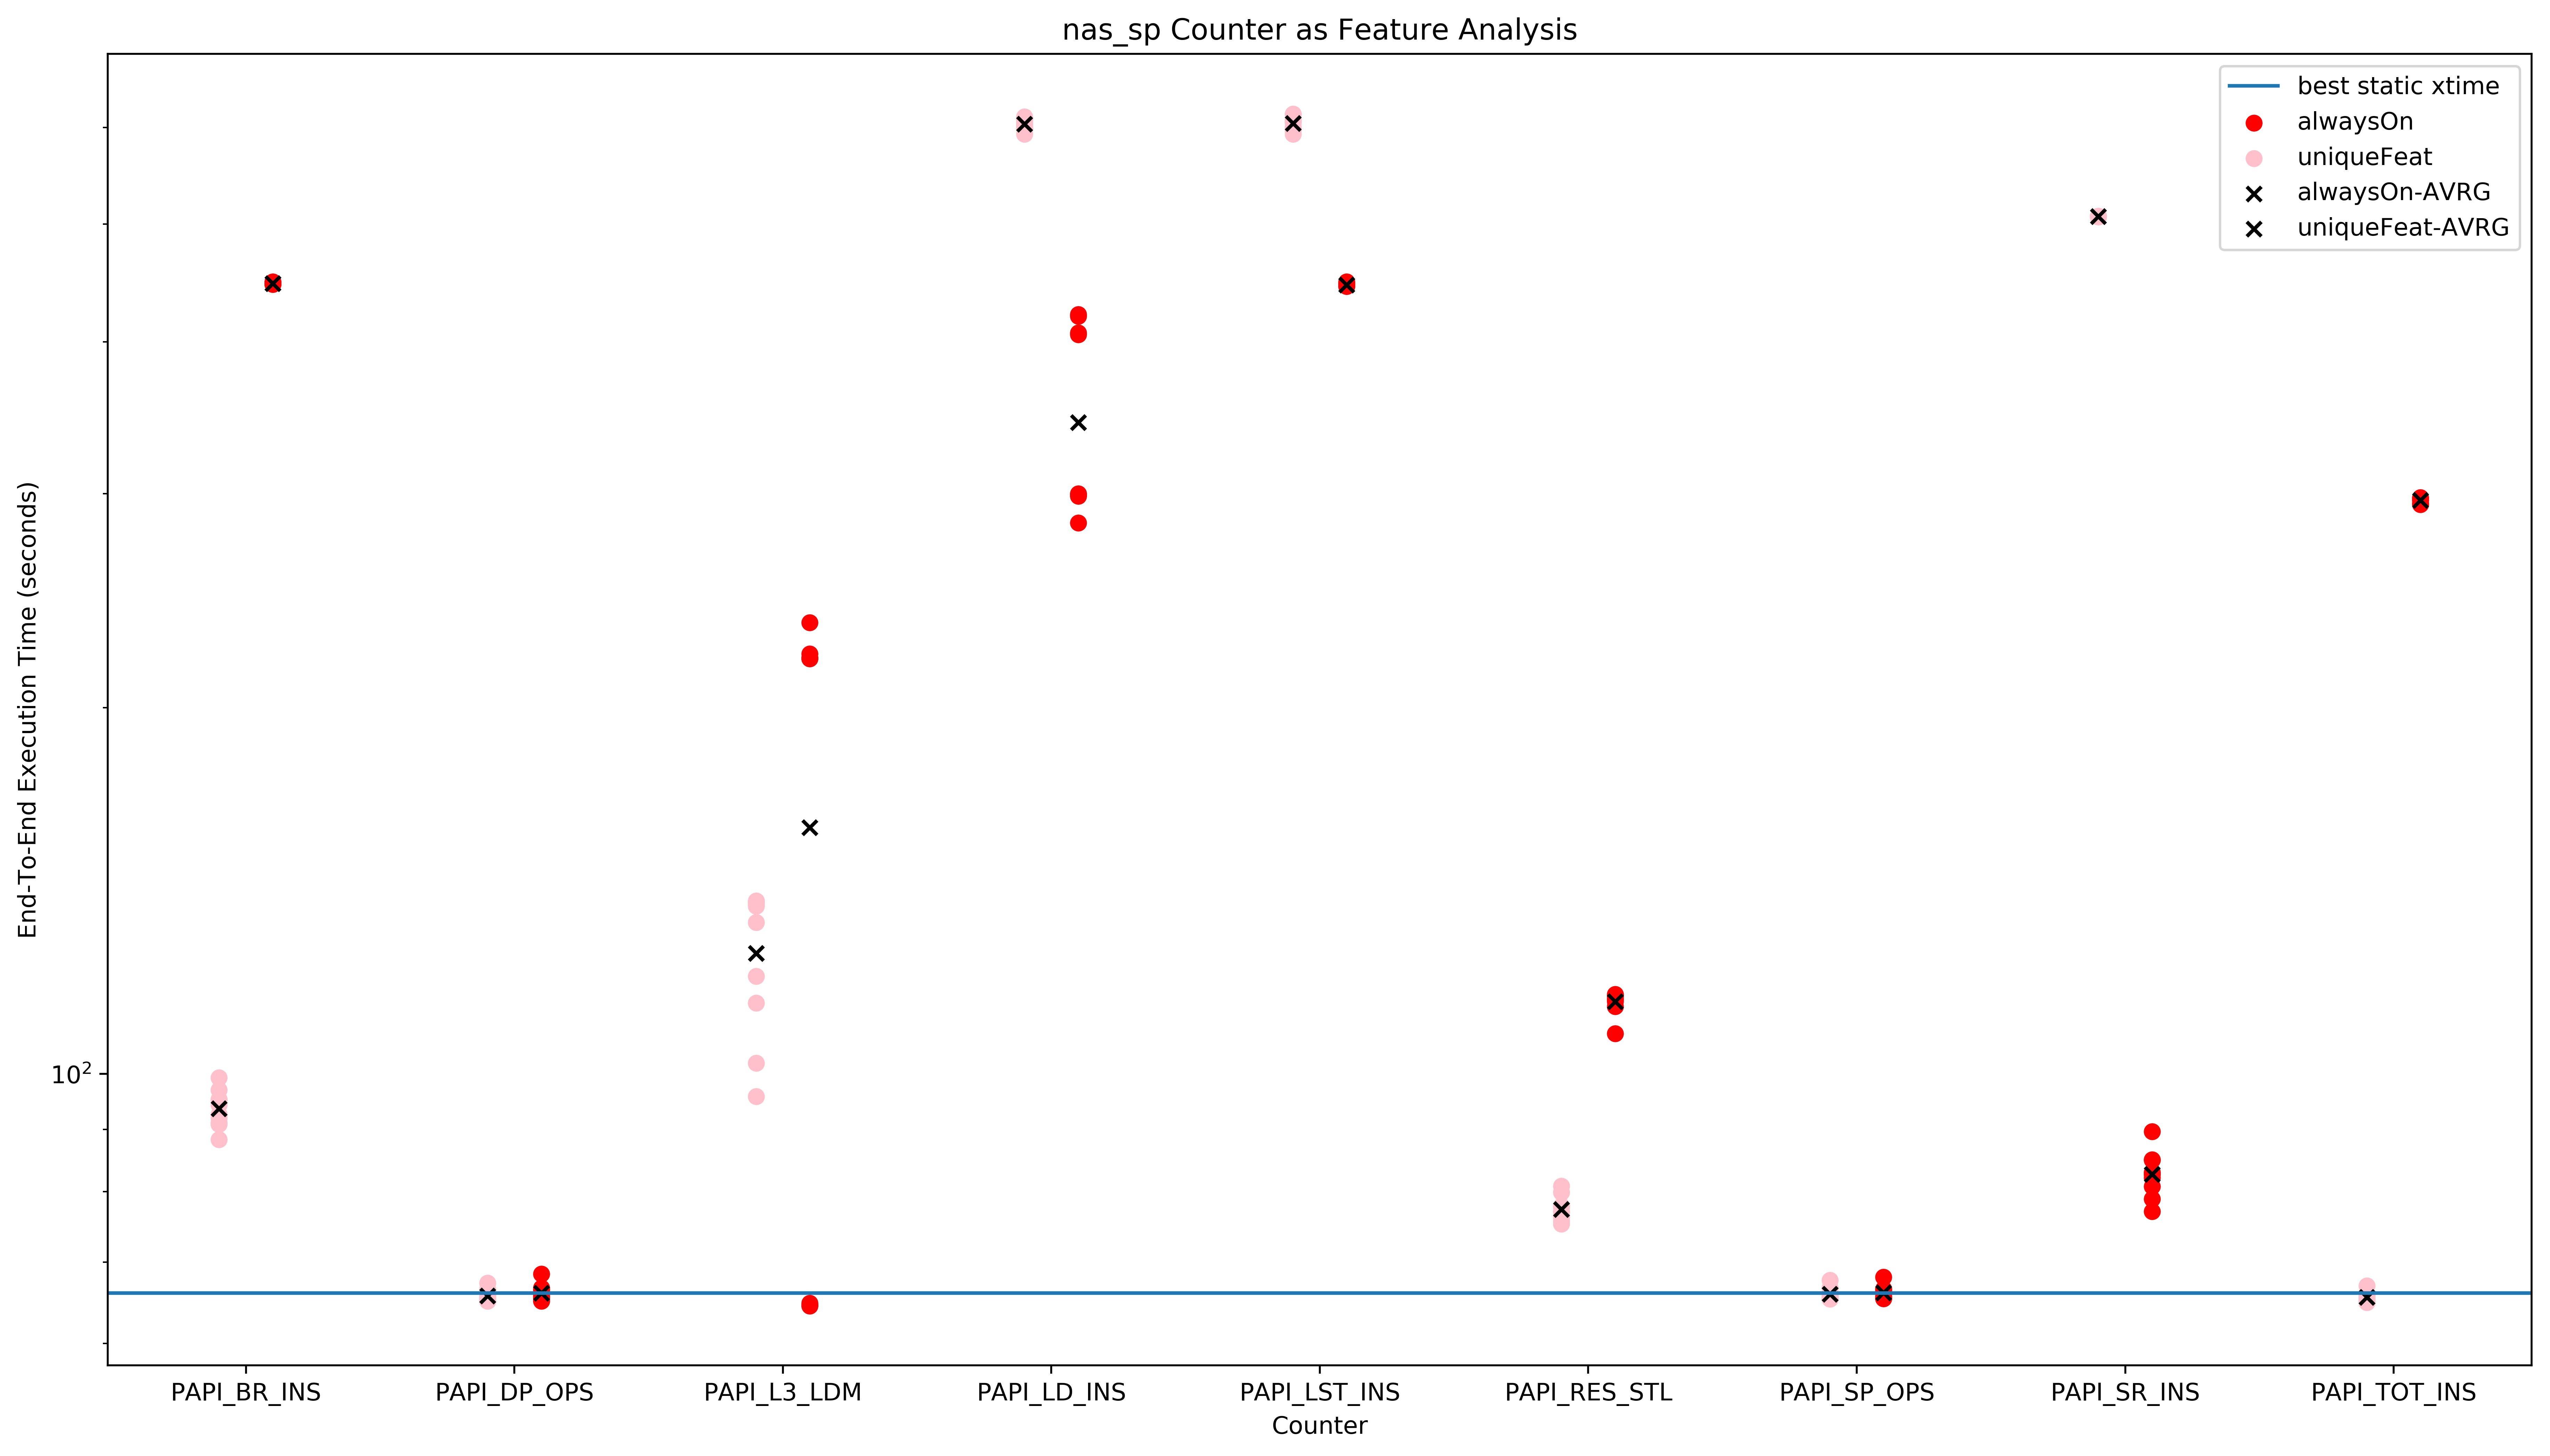

In [125]:
for prog in prognames:
    plotCntrTimingsForProg(prog, csvdf)